# 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング

顧客の属性情報などから定期預金キャンペーンの反応率を予測しよう。

https://signate.jp/competitions/292

LightGBM編

## ライブラリインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
#import featuretools as ft

#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

## 有効な関数

In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## データ読み込み・前処理

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 練習コンペのデータ
train_practice_df = pd.read_csv('train_practice.csv')
test_practice_df = pd.read_csv('test_practice.csv')

# オリジナルデータ
train_org_df = pd.read_csv('bank-full.csv', sep=';')

# Pseudo Labeling
test_p1_df = pd.read_csv('test_p1.csv')

# poutcome の前処理済みファイルを使う
#train_df = pd.read_csv('y_train-Copy1.csv')
#test_df = pd.read_csv('y_test-Copy1.csv')
#train2_df = pd.read_csv('y_train-Copy2.csv')
#test2_df = pd.read_csv('y_test-Copy2.csv')
#train3_df = pd.read_csv('y_train-Copy3.csv')
#test3_df = pd.read_csv('y_test-Copy3.csv')

submit_df = pd.read_csv('submit_sample.csv', header=None)

In [4]:
print(train_df.shape)
print(test_df.shape)
print(test_p1_df.shape)
print(train_practice_df.shape)
print(test_practice_df.shape)
print(train_org_df.shape)

(27100, 18)
(18050, 17)
(18050, 18)
(27128, 18)
(18083, 17)
(45211, 17)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27100 non-null  int64 
 1   age        27100 non-null  int64 
 2   job        27100 non-null  object
 3   marital    27100 non-null  object
 4   education  27100 non-null  object
 5   default    27100 non-null  object
 6   balance    27100 non-null  int64 
 7   housing    27100 non-null  object
 8   loan       27100 non-null  object
 9   contact    27100 non-null  object
 10  day        27100 non-null  int64 
 11  month      27100 non-null  object
 12  duration   27100 non-null  int64 
 13  campaign   27100 non-null  int64 
 14  pdays      27100 non-null  int64 
 15  previous   27100 non-null  int64 
 16  poutcome   27100 non-null  object
 17  y          27100 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [6]:
train_df['y'].value_counts()

0    24988
1     2112
Name: y, dtype: int64

In [7]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


In [8]:
test_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,35,technician,single,secondary,no,89043,no,no,cellular,7,feb,101,2,184,2,success
1,1,37,services,married,secondary,no,64372,yes,no,cellular,7,jul,158,3,241,0,unknown
2,2,31,services,single,secondary,no,31606,yes,no,unknown,15,may,152,2,47,0,unknown
3,3,31,admin.,married,secondary,no,94826,yes,no,cellular,27,may,345,2,490,0,unknown
4,4,32,services,married,secondary,no,100401,no,no,cellular,7,jan,126,1,686,0,other


In [9]:
train_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,13549.500000,36.073284,47682.901771,16.700443,229.325387,1.775830,432.482399,0.085720,0.077934
std,7823.240484,7.816417,31650.760036,8.576252,204.939958,0.950045,252.150648,0.365889,0.268072
min,0.000000,22.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6774.750000,31.000000,20015.750000,8.000000,121.000000,1.000000,214.000000,0.000000,0.000000
50%,13549.500000,33.000000,47624.000000,17.000000,158.000000,1.000000,432.000000,0.000000,0.000000
75%,20324.250000,37.000000,75330.000000,26.000000,345.000000,2.000000,650.000000,0.000000,0.000000
max,27099.000000,90.000000,102121.000000,31.000000,3076.000000,5.000000,870.000000,3.000000,1.000000


In [10]:
test_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,9024.500000,36.104266,47158.451801,16.697950,229.315014,1.770083,436.171801,0.090859
std,5210.730515,7.863805,31469.525699,8.580203,208.796946,0.944872,251.392519,0.375801
min,0.000000,20.000000,-6838.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,4512.250000,31.000000,19654.500000,8.000000,121.000000,1.000000,219.250000,0.000000
50%,9024.500000,33.000000,46886.000000,17.000000,158.000000,1.000000,436.000000,0.000000
75%,13536.750000,37.000000,74178.000000,26.000000,345.000000,2.000000,654.000000,0.000000
max,18049.000000,90.000000,102124.000000,31.000000,3076.000000,4.000000,870.000000,3.000000


In [11]:
stats = []
for col in train_df.columns:
    stats.append((col,
                  train_df[col].nunique(),
                  train_df[col].value_counts().index[0],
                  train_df[col].value_counts().values[0],
                  train_df[col].isnull().sum() * 100 / train_df.shape[0],
                  train_df[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                  train_df[col].dtype))
stats_df = pd.DataFrame(stats, columns=['カラム名', 'カラムごとのユニーク値数', '最も出現頻度の高い値', '最も出現頻度の高い値の出現回数', '欠損損値の割合', '最も多いカテゴリの割合', 'Type'])
stats_df

,カラム名,カラムごとのユニーク値数,最も出現頻度の高い値,最も出現頻度の高い値の出現回数,欠損損値の割合,最も多いカテゴリの割合,Type
0,id,27100,2047,1,0.0,0.003690,int64
1,age,42,31,4464,0.0,16.472325,int64
2,job,11,blue-collar,5957,0.0,21.981550,object
3,marital,3,married,17565,0.0,64.815498,object
4,education,4,secondary,15955,0.0,58.874539,object
5,default,2,no,27090,0.0,99.963100,object
6,balance,23967,31680,4,0.0,0.014760,int64
7,housing,2,yes,15819,0.0,58.372694,object
8,loan,2,no,23651,0.0,87.273063,object
9,contact,3,cellular,19147,0.0,70.653137,object


In [12]:
stats = []
for col in test_df.columns:
    stats.append((col,
                  test_df[col].nunique(),
                  test_df[col].value_counts().index[0],
                  test_df[col].value_counts().values[0],
                  test_df[col].isnull().sum() * 100 / test_df.shape[0],
                  test_df[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                  test_df[col].dtype))
stats_df = pd.DataFrame(stats, columns=['カラム名', 'カラムごとのユニーク値数', '最も出現頻度の高い値', '最も出現頻度の高い値の出現回数', '欠損損値の割合', '最も多いカテゴリの割合', 'Type'])
stats_df

,カラム名,カラムごとのユニーク値数,最も出現頻度の高い値,最も出現頻度の高い値の出現回数,欠損損値の割合,最も多いカテゴリの割合,Type
0,id,18050,2047,1,0.0,0.005540,int64
1,age,41,31,3068,0.0,16.997230,int64
2,job,12,blue-collar,4086,0.0,22.637119,object
3,marital,3,married,11653,0.0,64.559557,object
4,education,4,secondary,10799,0.0,59.828255,object
5,default,2,no,18046,0.0,99.977839,object
6,balance,16635,28881,5,0.0,0.027701,int64
7,housing,2,yes,10418,0.0,57.717452,object
8,loan,2,no,15729,0.0,87.141274,object
9,contact,3,cellular,12607,0.0,69.844875,object


In [13]:
# Pseudo Labeling
train_df = pd.concat([train_df, test_p1_df])

In [14]:
# job のラベリングを y の平均の低い順にしてみる
#train_df.groupby('job').mean().sort_values('y')

In [15]:
train_df.drop(['id'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)

train_org_df['y'] = train_org_df['y'].map(dict(yes=1, no=0))

#train_df = pd.concat([train_df, train_org_df])

In [16]:
# job別 平均 残高
#balance_job_mean = train_df.groupby('job')['balance'].mean()


データメモ

- testデータの `job` に `unknown` が一人いる (trainデータにはいない)

In [17]:
# one hot encoding
#train_df = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df.drop(['job_unknown'], axis=1, inplace=True)

df_list = [train_df, test_df, train_org_df]

#train_df['poutcome'] = (train_df['poutcome'] + train2_df['poutcome'] + train3_df['poutcome']) / 3
#test_df['poutcome'] = (test_df['poutcome'] + test2_df['poutcome'] + test3_df['poutcome']) / 3

#job_encoder = LabelEncoder()
#job_encoder.fit(test_df['job'])

#job_label_mean = train_df.groupby('job')['y'].mean()

for df in df_list:
    #df['balancejob'] = df['balance'] - df['job'].map(balance_job_mean)
    
    #df['job'] = job_encoder.transform(df['job'])
    df['job'] = df['job'].map({'unknown': 1, 'technician': 2, 'blue-collar': 3, 'services': 4, 'entrepreneur': 5, 'admin.': 6, 'management': 7, 'housemaid': 8, 'self-employed': 9, 'unemployed': 10, 'retired': 11, 'student': 12})

    # Target Mean Encoding
    #df['target_job'] = df['job'].map(job_label_mean)
    #df.drop(['job'], axis=1, inplace=True)

    df['marital'] = df['marital'].map({'married': 2, 'divorced':1, 'single': 0})
    #df.drop(['marital'], axis=1, inplace=True)

    df['education'] = df['education'].map({'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0})
    #df.drop(['education'], axis=1, inplace=True)

    #df['default'] = df['default'].map({'yes': 1, 'no': 0})
    df.drop(['default'], axis=1, inplace=True)

    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    #df.drop(['housing'], axis=1, inplace=True)
    
    df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    #df.drop(['loan'], axis=1, inplace=True)

    df['contact'] = df['contact'].map({'telephone': 2, 'cellular': 1, 'unknown': 0})
    #df.drop(['contact'], axis=1, inplace=True)

    df['poutcome'] = df['poutcome'].map({'success': 3, 'unknown': 2, 'failure': 1, 'other': 0})
    
    df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    #df.drop(['day', 'month'], axis=1, inplace=True)
    
    # Feb 30 とかあって、正確には変換できない
    # → データの Feb 30 を Mar 1 に変換した(他にも、 2/31, 6/31, 11/31)
    #df['dayofyear'] = df['month'] * 31 + df['day']
    df['datetime'] = pd.to_datetime('2012/' + df['month'].astype(str).str.pad(2,fillchar='0') + '/' + df['day'].astype(str).str.pad(2,fillchar='0'), format='%Y/%m/%d')
    df['dayofyear'] = df['datetime'].dt.dayofyear
    #df['dayofweek'] = df['datetime'].dt.dayofweek
    df.drop(['datetime'], axis=1, inplace=True)
    
    #df['duration'] = np.log(df['duration'] + 1)
    #df['bpp'] = np.log((df['balance'] - df['balance'].min()) / (df['pdays'] + 2) + 1)
    
    #df.drop(['id'], axis=1, inplace=True)
    
    df['cdp'] = (df['campaign'] - df['previous']) * df['duration']
    
    df.drop(['pdays'], axis=1, inplace=True)
    df.drop(['balance'], axis=1, inplace=True)
    
# featuretools用
#y = train_df.pop('y')
#train_df['train'] = 1
#test_df['train'] = 0
#test_df['id'] = test_df['id'] + len(train_df)

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45150 entries, 0 to 18049
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        45150 non-null  int64
 1   job        45150 non-null  int64
 2   marital    45150 non-null  int64
 3   education  45150 non-null  int64
 4   housing    45150 non-null  int64
 5   loan       45150 non-null  int64
 6   contact    45150 non-null  int64
 7   day        45150 non-null  int64
 8   month      45150 non-null  int64
 9   duration   45150 non-null  int64
 10  campaign   45150 non-null  int64
 11  previous   45150 non-null  int64
 12  poutcome   45150 non-null  int64
 13  y          45150 non-null  int64
 14  dayofyear  45150 non-null  int64
 15  cdp        45150 non-null  int64
dtypes: int64(16)
memory usage: 5.9 MB


In [19]:
train_df.head()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,dayofyear,cdp
0,31,4,2,2,1,0,1,21,11,101,3,0,0,0,326,303
1,29,5,0,3,0,0,1,22,8,158,2,0,2,1,235,316
2,35,7,2,3,1,0,1,11,11,351,1,0,1,0,316,351
3,31,2,2,2,1,1,0,16,5,658,2,0,1,0,137,1316
4,48,10,2,1,1,0,2,3,4,177,1,0,2,0,94,177


In [20]:
test_df.head()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,dayofyear,cdp
0,35,2,0,2,0,0,1,7,2,101,2,2,3,38,0
1,37,4,2,2,1,0,1,7,7,158,3,0,2,189,474
2,31,4,0,2,1,0,0,15,5,152,2,0,2,136,304
3,31,6,2,2,1,0,1,27,5,345,2,0,2,148,690
4,32,4,2,2,0,0,1,7,1,126,1,0,0,7,126


In [21]:
train_df.describe()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,dayofyear,cdp
count,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000,45150.000000
mean,36.085670,5.139668,1.384563,2.043477,0.581107,0.127796,0.786401,16.699446,6.001617,229.321240,1.773533,0.087774,1.856633,0.078760,168.562769,370.942924
std,7.835323,2.662201,0.872828,0.723352,0.493383,0.333866,0.501080,8.577737,2.128473,206.488239,0.947974,0.369888,0.465919,0.269366,64.939227,418.401753
min,20.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,-2674.000000
25%,31.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,8.000000,5.000000,121.000000,1.000000,0.000000,2.000000,0.000000,136.000000,152.000000
50%,33.000000,5.000000,2.000000,2.000000,1.000000,0.000000,1.000000,17.000000,5.000000,158.000000,1.000000,0.000000,2.000000,0.000000,148.000000,304.000000
75%,37.000000,7.000000,2.000000,2.000000,1.000000,0.000000,1.000000,26.000000,7.000000,345.000000,2.000000,0.000000,2.000000,0.000000,199.000000,456.000000
max,90.000000,12.000000,2.000000,3.000000,1.000000,1.000000,2.000000,31.000000,12.000000,3076.000000,5.000000,3.000000,3.000000,1.000000,336.000000,12304.000000


In [22]:
test_df.describe()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,dayofyear,cdp
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,36.104266,5.120388,1.382161,2.039501,0.577175,0.128587,0.783989,16.697950,5.998726,229.315014,1.770083,0.090859,1.858061,168.471468,371.912299
std,7.863805,2.650421,0.873514,0.717774,0.494022,0.334752,0.504881,8.580203,2.118452,208.796946,0.944872,0.375801,0.464028,64.614438,436.815067
min,20.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,-2054.000000
25%,31.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,8.000000,5.000000,121.000000,1.000000,0.000000,2.000000,136.000000,152.000000
50%,33.000000,5.000000,2.000000,2.000000,1.000000,0.000000,1.000000,17.000000,5.000000,158.000000,1.000000,0.000000,2.000000,148.000000,304.000000
75%,37.000000,7.000000,2.000000,2.000000,1.000000,0.000000,1.000000,26.000000,7.000000,345.000000,2.000000,0.000000,2.000000,199.000000,456.000000
max,90.000000,12.000000,2.000000,3.000000,1.000000,1.000000,2.000000,31.000000,12.000000,3076.000000,4.000000,3.000000,3.000000,336.000000,12304.000000


In [23]:
# featuretools による総当り特徴量生成

#df = pd.concat([train_df, test_df])

#es = ft.EntitySet(id='bank')
#es.entity_from_dataframe(entity_id='bank', dataframe=df, index='id')
#feature_matrix, feature_defs = ft.dfs(
#    entityset=es,
#    target_entity='bank',
#    trans_primitives=['subtract_numeric'],
#    agg_primitives=[],
#    max_depth=1,
#)

#df_dict = {}
#for name, group in feature_matrix.groupby('train'):
#    df_dict[name] = group
    
#train_df = df_dict[1]
#test_df = df_dict[0]

#train_df.drop(['train'], axis=1, inplace=True)
#test_df.drop(['train'], axis=1, inplace=True)


In [24]:
#train_df.head()

In [25]:
#test_df.head()

In [26]:
#train_df.info()

In [27]:
#train_pg = sns.pairplot(train_df.drop(['month', 'day'], axis=1), hue='y')
#train_pg = sns.pairplot(train_df, hue='y')
#train_pg.savefig('train_df.png')

#test_pg = sns.pairplot(test_df)
#test_pg.savefig('test_df.png')

In [28]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 5.86 MB
Memory usage after optimization is: 1.16 MB
Decreased by 80.1%
Memory usage of dataframe is 2.07 MB
Memory usage after optimization is: 0.31 MB
Decreased by 85.0%


In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45150 entries, 0 to 18049
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        45150 non-null  int8 
 1   job        45150 non-null  int8 
 2   marital    45150 non-null  int8 
 3   education  45150 non-null  int8 
 4   housing    45150 non-null  int8 
 5   loan       45150 non-null  int8 
 6   contact    45150 non-null  int8 
 7   day        45150 non-null  int8 
 8   month      45150 non-null  int8 
 9   duration   45150 non-null  int16
 10  campaign   45150 non-null  int8 
 11  previous   45150 non-null  int8 
 12  poutcome   45150 non-null  int8 
 13  y          45150 non-null  int8 
 14  dayofyear  45150 non-null  int16
 15  cdp        45150 non-null  int16
dtypes: int16(3), int8(13)
memory usage: 1.2 MB


In [30]:
class TunerCVCheckpointCallback(object):
    """Optuna の LightGBMTunerCV から学習済みモデルを取り出すためのコールバック"""

    def __init__(self):
        # オンメモリでモデルを記録しておく辞書
        self.cv_boosters = {}
        self.cv_score = {}

    @staticmethod
    def params_to_hash(params):
        """パラメータを元に辞書のキーとなるハッシュを計算する"""
        params_hash = hash(frozenset(params.items()))
        return params_hash

    def get_trained_model(self, params):
        """パラメータをキーとして学習済みモデルを取り出す"""
        params_hash = self.params_to_hash(params)
        return self.cv_boosters[params_hash]

    def __call__(self, env):
        """LightGBM の各ラウンドで呼ばれるコールバック"""
        # 学習に使うパラメータをハッシュ値に変換する
        params_hash = self.params_to_hash(env.params)
        # 初登場のパラメータならモデルへの参照を保持する
        #if params_hash not in self.cv_boosters:
        #    self.cv_boosters[params_hash] = env.model
        
        # 保存済みのパラメータよりスコアが良ければモデルを保存する
        score = env.evaluation_result_list[0][2]
        if (
            params_hash not in self.cv_score
            or score > self.cv_score[params_hash]
        ):
            self.cv_score[params_hash] = score
            self.cv_boosters[params_hash] = env.model


## 学習準備

In [31]:
y = train_df.pop('y')

#X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=44)
#X_train, X_test, y_train, y_test = train_test_split(train_df, y, random_state=44)

#train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
#test_data = lgb.Dataset(data=X_test, label=y_test, free_raw_data=False)
final_train_set = lgb.Dataset(data=train_df, label=y, free_raw_data=False)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# 学習済みモデルへの参照を保持するためのコールバック
checkpoint_cb = TunerCVCheckpointCallback()
callbacks = [
    checkpoint_cb,
]

## ハイパーパラメータ

In [32]:
lgb_params = {
    'objective': 'binary',     # Binary classification
    'metric': 'auc',  # Area under ROC curve as the evaulation metric
    'random_state': 22,
    'learning_rate': 0.01,
    # 以下はoptunaでチューニングする
    #'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    #'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    #'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    #'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    #'drop_rate': 0.15
}

## 学習

In [33]:
tuner = optuna_lgb.LightGBMTunerCV(
    lgb_params,
    final_train_set,
    num_boost_round=10000,
    early_stopping_rounds=100,
    verbose_eval=0,
    folds=folds,
    callbacks=callbacks,
)
tuner.run()

# NOTE: 念のためハッシュの衝突に備えて Trial の数と学習済みモデルの数を比較しておく
#assert len(checkpoint_cb.cv_boosters) == len(tuner.study.trials) - 1

# 最も良かったパラメータをキーにして学習済みモデルを取り出す
cv_booster = checkpoint_cb.get_trained_model(tuner.best_params)

print("  Params: ")
for key, value in tuner.best_params.items():
    print("    {}: {}".format(key, value))

min_data_in_leaf, val_score: 0.919457: 100%|##########| 5/5 [02:52<00:00, 34.42s/it]


  Params: 
    objective: binary
    metric: auc
    random_state: 22
    learning_rate: 0.01
    lambda_l1: 0.0884648962118597
    lambda_l2: 2.492342769132256
    num_leaves: 4
    feature_fraction: 0.4
    bagging_fraction: 0.7823078260821351
    bagging_freq: 4
    min_child_samples: 20


In [34]:
#evaluation_results = {}

#clf = lgb.train(
#    train_set=train_data,
#    params=tuner.best_params,
#    valid_sets=[train_data, test_data], 
#    valid_names=['Train', 'Test'],
#    evals_result=evaluation_results,
#    num_boost_round=1000,
#    early_stopping_rounds=100,
#    verbose_eval=100
#)
#optimum_boost_rounds = clf.best_iteration

#print('Result:')
#print(clf.params)
#print(clf.best_score)

## 可視化

In [35]:
#fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
#axs[0].plot(evaluation_results['Train']['auc'], label='Train')
#axs[0].plot(evaluation_results['Test']['auc'], label='Test')
#axs[0].set_ylabel('AUC')
#axs[0].set_xlabel('Boosting round')
#axs[0].set_title('Training performance')
#axs[0].legend()

# Plot feature importance
#importances = pd.DataFrame({'features': cv_booster.feature_name(), 
#                            'importance': cv_booster.feature_importance()}).sort_values('importance', ascending=False)
#axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
#axs[1].set_xticks(np.arange(len(importances)))
#axs[1].set_xticklabels(importances['features'], rotation = 45)
#axs[1].set_ylabel('Feature importance (# times used to split)')
#axs[1].set_title('Feature importance')

#plt.show()

In [36]:
#importances.sort_values('importance')

In [37]:
border = round(1 - y.sum() / y.count(), 2)

preds = np.average(np.array(cv_booster.predict(train_df)), axis=0)
preds_df = pd.DataFrame(preds)

pred_border = float(preds_df.quantile(border))
pred_border

0.28609246008696376

In [38]:
y_pred = np.where(preds > pred_border, 1, 0)
print('Accuracy score = \t {}'.format(accuracy_score(y, y_pred)))
print('Precision score = \t {}'.format(precision_score(y, y_pred)))
print('Recall score =   \t {}'.format(recall_score(y, y_pred)))
print('F1 score =      \t {}'.format(f1_score(y, y_pred)))

Accuracy score = 	 0.9481284606866002
Precision score = 	 0.6680509413067552
Recall score =   	 0.6785714285714286
F1 score =      	 0.6732700892857143


In [39]:
fpr, tpr, thresholds = roc_curve(y, preds)
auc_score = auc(fpr, tpr)
print(auc_score)

0.9305220498024369


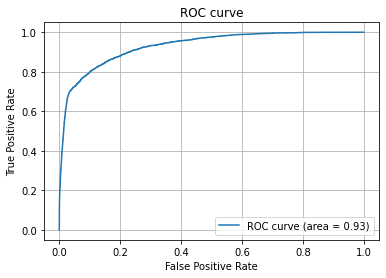

In [40]:
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc_score)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## 推論

In [41]:
test_pred = np.array(cv_booster.predict(test_df, num_iteration=cv_booster.best_iteration)).mean(axis=0)

In [42]:
submit_df[1] = test_pred
submit_df.to_csv('submit-lg.csv', header=False, index=False)

In [43]:
submit_df.head()

,0,1
0,0,0.850292
1,1,0.059430
2,2,0.011450
3,3,0.001065
4,4,0.013674


(array([11795.,  2242.,   956.,   564.,   361.,   267.,   227.,   139.,
           96.,   107.,   111.,    89.,   115.,    89.,    72.,    57.,
           55.,    77.,    50.,    54.,    58.,    58.,    45.,    38.,
           51.,    40.,    55.,    55.,    57.,    70.]),
 array([1.11954644e-04, 3.34204392e-02, 6.67289238e-02, 1.00037408e-01,
        1.33345893e-01, 1.66654378e-01, 1.99962862e-01, 2.33271347e-01,
        2.66579831e-01, 2.99888316e-01, 3.33196800e-01, 3.66505285e-01,
        3.99813770e-01, 4.33122254e-01, 4.66430739e-01, 4.99739223e-01,
        5.33047708e-01, 5.66356192e-01, 5.99664677e-01, 6.32973162e-01,
        6.66281646e-01, 6.99590131e-01, 7.32898615e-01, 7.66207100e-01,
        7.99515584e-01, 8.32824069e-01, 8.66132554e-01, 8.99441038e-01,
        9.32749523e-01, 9.66058007e-01, 9.99366492e-01]),
 <BarContainer object of 30 artists>)

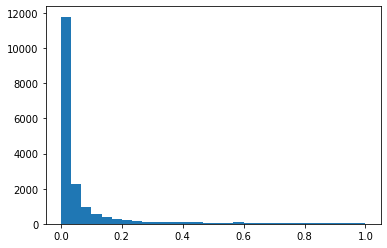

In [44]:
#pseudo labeling

plt.hist(test_pred, bins=30)

In [45]:
test_pred_df = pd.DataFrame(test_pred)

border = round(1 - y.sum() / y.count(), 2)
border

0.92

In [46]:
percentile_list = [.01, .25, .5, .75, border]
test_pred_df.describe(percentile_list)

,0
count,18050.000000
mean,0.078677
std,0.169963
min,0.000112
1%,0.000700
25%,0.004213
50%,0.016015
75%,0.056931
92%,0.285253
max,0.999366


In [47]:
pred_border = float(test_pred_df.quantile(border))
pred_border

0.28525258481675503

In [48]:
round_test_pred = np.array(list(map(lambda x: 0 if x < pred_border else 1, test_pred)))
round_test_pred

array([1, 0, 0, ..., 0, 0, 0])

In [49]:
test_df['y'] = round_test_pred
#test_df['y'] = np.round(test_pred).astype('int64')
#test_df.to_csv('test_p1.csv', index=False)

In [50]:
test_df.head()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,dayofyear,cdp,y
0,35,2,0,2,0,0,1,7,2,101,2,2,3,38,0,1
1,37,4,2,2,1,0,1,7,7,158,3,0,2,189,474,0
2,31,4,0,2,1,0,0,15,5,152,2,0,2,136,304,0
3,31,6,2,2,1,0,1,27,5,345,2,0,2,148,690,0
4,32,4,2,2,0,0,1,7,1,126,1,0,0,7,126,0


In [51]:
round(1 - round_test_pred.sum() / len(round_test_pred), 2)

0.92